In [8]:
import findspark
from pyspark import SparkConf
from pyspark.sql import SparkSession  #Connect spark code on top of spark engine
spark = SparkSession.builder.master("local[1]").getOrCreate()

In [ ]:
#pip install pyspark

In [9]:
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf, col, concat, count, lit, avg, lag, first, last, when
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround

from pyspark.sql.types import IntegerType, DateType, TimestampType, StringType

from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LinearSVC, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

In [10]:
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [11]:
path = "/content/mini_sparkify_event_data.json"

In [13]:
df = spark.read.json(path)

In [14]:
df.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- firstNamion: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- itemInSessione: string (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [15]:
print("The number of rows is {}".format(df.count()))
print("The number of columns is {}".format(len(df.columns)))

The number of rows is 30860
The number of columns is 21


In [16]:
# Number of duplicates
df.count() - df.dropDuplicates().count()

4741

In [17]:
# convert the timestamps into datetime format and add them to the dataframe, for a clearer understanding
from pyspark.sql.types import IntegerType, DateType, TimestampType, StringType
df = df.withColumn('registrationDate', (df['registration'] / 1000).cast(TimestampType()))
df = df.withColumn('tsDate', (df['ts'] / 1000).cast(TimestampType()))

In [18]:
df.select('userId', 'page', 'song', 'ts', 'tsDate').sort('ts').show(10)

+------+--------+-----------------+-------------+-------------------+
|userId|    page|             song|           ts|             tsDate|
+------+--------+-----------------+-------------+-------------------+
|  null|    null|             null|         null|               null|
|  null|    null|             null|         null|               null|
|  null|    null|             null|         null|               null|
|  null|    null|             null|         null|               null|
|  null|    null|             null|         null|               null|
|  null|    null|             null|         null|               null|
|  null|    null|             null|         null|               null|
|    30|NextSong|        Rockpools|1538352117000|2018-10-01 00:01:57|
|     9|NextSong|           Canada|1538352180000|2018-10-01 00:03:00|
|    30|NextSong|Time For Miracles|1538352394000|2018-10-01 00:06:34|
+------+--------+-----------------+-------------+-------------------+
only showing top 10 

In [19]:
df.select('userId', 'page', 'song', 'ts', 'tsDate').sort('ts', ascending = False).show(10)

+------+--------+--------------------+-------------+-------------------+
|userId|    page|                song|           ts|             tsDate|
+------+--------+--------------------+-------------+-------------------+
|    15|NextSong|     Sol de invierno|1539085348000|2018-10-09 11:42:28|
|   101|NextSong|       Irreplaceable|1539085298000|2018-10-09 11:41:38|
|    29|NextSong|          Down Rodeo|1539085288000|2018-10-09 11:41:28|
|    58|NextSong|Sugar Ray (LP Ver...|1539085251000|2018-10-09 11:40:51|
|    29|NextSong|   Swamps Of Sadness|1539085174000|2018-10-09 11:39:34|
|    39|NextSong|    Through The Fire|1539085164000|2018-10-09 11:39:24|
|    15|NextSong|Don't Stop The Music|1539085080000|2018-10-09 11:38:00|
|   101|NextSong| Have You Forgotten?|1539085054000|2018-10-09 11:37:34|
|    58|NextSong|El reloj de la pa...|1539084989000|2018-10-09 11:36:29|
|    39|    Home|                null|1539084981000|2018-10-09 11:36:21|
+------+--------+--------------------+-------------

In [20]:
# Remove rows with corrupted timestamps
df = df.where(df.ts <= 1543622399000)
df.count()

30853

In [21]:
df.select(['userId', 'firstName', 'lastName', 'gender', 'location', 'registration', 'registrationDate', 'userAgent', 'level']).show(5)

+------+---------+--------+------+--------------------+-------------+-------------------+--------------------+-----+
|userId|firstName|lastName|gender|            location| registration|   registrationDate|           userAgent|level|
+------+---------+--------+------+--------------------+-------------+-------------------+--------------------+-----+
|    30|    Colin| Freeman|     M|     Bakersfield, CA|1538173362000|2018-09-28 22:22:42|Mozilla/5.0 (Wind...| paid|
|     9|    Micah|    Long|     M|Boston-Cambridge-...|1538331630000|2018-09-30 18:20:30|"Mozilla/5.0 (Win...| free|
|    30|    Colin| Freeman|     M|     Bakersfield, CA|1538173362000|2018-09-28 22:22:42|Mozilla/5.0 (Wind...| paid|
|     9|    Micah|    Long|     M|Boston-Cambridge-...|1538331630000|2018-09-30 18:20:30|"Mozilla/5.0 (Win...| free|
|    30|    Colin| Freeman|     M|     Bakersfield, CA|1538173362000|2018-09-28 22:22:42|Mozilla/5.0 (Wind...| paid|
+------+---------+--------+------+--------------------+---------

In [22]:

# Number of unique users in the dataset
print("Number of unique users is {}".format(df.select(['userId']).dropDuplicates().count()))
# Number of missing values in the 'userId' column
print("Number of missing values in the 'userId' column is {}".format(df.where(df.userId.isNull()).count()))

Number of unique users is 118
Number of missing values in the 'userId' column is 0


In [23]:
# Rows with empty strings in the 'userId' column.
df.where(df.userId == "").count()

972

In [24]:
df.where(df.userId == "").select(['userId', 'firstName', 'lastName', 'gender', 'location', 'registration', 'userAgent', 'level', 'tsDate', 'page', 'auth',]).show(10)
df.where(df.userId == "").groupby('auth').count().show()

+------+---------+--------+------+--------+------------+---------+-----+-------------------+-----+----------+
|userId|firstName|lastName|gender|location|registration|userAgent|level|             tsDate| page|      auth|
+------+---------+--------+------+--------+------------+---------+-----+-------------------+-----+----------+
|      |     null|    null|  null|    null|        null|     null| free|2018-10-01 01:02:25| Home|Logged Out|
|      |     null|    null|  null|    null|        null|     null| free|2018-10-01 01:03:27| Help|Logged Out|
|      |     null|    null|  null|    null|        null|     null| free|2018-10-01 01:04:01| Home|Logged Out|
|      |     null|    null|  null|    null|        null|     null| free|2018-10-01 01:04:02|Login|Logged Out|
|      |     null|    null|  null|    null|        null|     null| free|2018-10-01 01:17:58| Home|Logged Out|
|      |     null|    null|  null|    null|        null|     null| free|2018-10-01 01:17:59|Login|Logged Out|
|      |  

In [25]:
#  Log-specific information
df.select(['ts', 'tsDate', 'page', 'auth', 'sessionId', 'itemInSession', 'method', 'status']).show(5)

+-------------+-------------------+--------+---------+---------+-------------+------+------+
|           ts|             tsDate|    page|     auth|sessionId|itemInSession|method|status|
+-------------+-------------------+--------+---------+---------+-------------+------+------+
|1538352117000|2018-10-01 00:01:57|NextSong|Logged In|       29|           50|   PUT|   200|
|1538352180000|2018-10-01 00:03:00|NextSong|Logged In|        8|           79|   PUT|   200|
|1538352394000|2018-10-01 00:06:34|NextSong|Logged In|       29|           51|   PUT|   200|
|1538352416000|2018-10-01 00:06:56|NextSong|Logged In|        8|           80|   PUT|   200|
|1538352676000|2018-10-01 00:11:16|NextSong|Logged In|       29|           52|   PUT|   200|
+-------------+-------------------+--------+---------+---------+-------------+------+------+
only showing top 5 rows



In [26]:
df.groupby('method').count().show()

+------+-----+
|method|count|
+------+-----+
|  null|    1|
|   PUT|27653|
|   GET| 3199|
+------+-----+



In [27]:
df.groupby('status').count().show()

+------+-----+
|status|count|
+------+-----+
|  null|    1|
|   307| 2730|
|   404|   39|
|   200|28083|
+------+-----+



In [28]:

# '404' status corresponds to 'Error' in the page column.

df.where(df.status == '404').select(['userId', 'tsDate', 'sessionId', 'status', 'page']).show(5)

+------+-------------------+---------+------+-----+
|userId|             tsDate|sessionId|status| page|
+------+-------------------+---------+------+-----+
|   131|2018-10-01 11:37:28|      249|   404|Error|
|   140|2018-10-01 15:32:07|      139|   404|Error|
|   124|2018-10-05 07:20:12|      420|   404|Error|
|    91|2018-10-05 08:42:28|       90|   404|Error|
|    91|2018-10-05 11:33:25|       90|   404|Error|
+------+-------------------+---------+------+-----+
only showing top 5 rows



In [29]:
print("Number of missing values in the 'page' column is {}".format(df.where(df.page.isNull()).count()))

Number of missing values in the 'page' column is 0


In [30]:

# pages types

pages_num = df.select('page').dropDuplicates().count()
df.select('page').dropDuplicates().show(pages_num)
print("Number of user actions is {}".format(pages_num))

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|               Login|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+

Number of user actions is 20


No handles with labels found to put in legend.


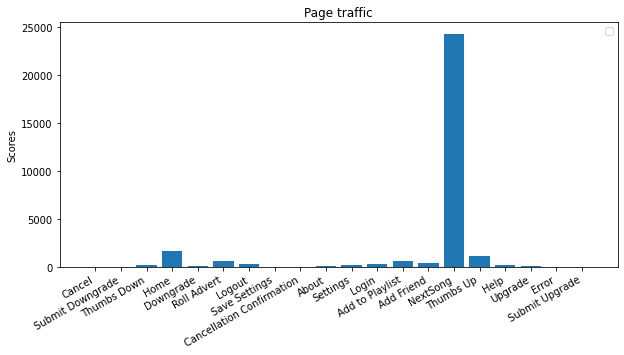

UsageError: Line magic function `%matplot` not found.


In [31]:
# plotting most often uses pages
import matplotlib.pyplot as plt

pages_df = df.groupby('page').count().toPandas()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(pages_df['page'], pages_df['count'])
ax.set_ylabel('Scores')
ax.set_title('Page traffic')
ax.legend()
fig.autofmt_xdate()

plt.show()

%matplot plt

In [32]:
df.groupby('auth').count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out|  972|
| Cancelled|    2|
|Loggem, CA|    1|
| Logged In|29878|
+----------+-----+



In [33]:
print("Number of sessionId is {}".format(df.select('sessionId').dropDuplicates().count()))
print("Number of missing values in the sessionId column is {}".format(df.where(df.sessionId.isNull()).count()))
print("Number of empty values in the sessionId column is {}".format(df.where(df.sessionId == "").count()))

Number of sessionId is 393
Number of missing values in the sessionId column is 0
Number of empty values in the sessionId column is 0


In [34]:

# explore maximum and minimum session length 
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround
sessions_df = df.where(df.userId != "").groupby(['userId','sessionId']) \
                                            .agg(((Fmax('ts') - Fmin('ts'))/1000).alias('sessionlength'))

sessions_df.sort('sessionlength', ascending = False).show(5)
sessions_df.where(sessions_df.sessionlength != 0).sort('sessionlength', ascending = True).show(5)

+------+---------+-------------+
|userId|sessionId|sessionlength|
+------+---------+-------------+
|   115|      316|     222919.0|
|    51|      236|     124163.0|
|   141|      479|     111728.0|
|   101|      496|      95332.0|
|   124|      420|      93567.0|
+------+---------+-------------+
only showing top 5 rows

+------+---------+-------------+
|userId|sessionId|sessionlength|
+------+---------+-------------+
|    30|      264|          1.0|
|   122|      403|          1.0|
|     5|      380|          1.0|
|    52|      253|          1.0|
|    95|      445|         12.0|
+------+---------+-------------+
only showing top 5 rows



In [35]:
# Song-level information
df.select(['artist', 'song', 'length']).show(5)

+----------------+--------------------+---------+
|          artist|                song|   length|
+----------------+--------------------+---------+
|  Martha Tilston|           Rockpools|277.89016|
|Five Iron Frenzy|              Canada|236.09424|
|    Adam Lambert|   Time For Miracles| 282.8273|
|          Enigma|Knocking On Forbi...|262.71302|
|       Daft Punk|Harder Better Fas...|223.60771|
+----------------+--------------------+---------+
only showing top 5 rows



In [36]:
# number of listen songs
df.where(df.page == 'NextSong').groupby('page').count().show()

+--------+-----+
|    page|count|
+--------+-----+
|NextSong|24276|
+--------+-----+



In [37]:
print("Number of different artists is {}".format(df.where(df.artist.isNotNull()).select('artist').dropDuplicates().count()))
print("Number of different song names is {}".format(df.where(df.song.isNotNull()).select('song').dropDuplicates().count()))
print("Number of songs in dataset (including full duplicates) is {}".format(df.select(['artist','song','length']).dropDuplicates().count()))
print("Number of songs in dataset (including duplicates with same artist and song name) is {}".format(df.select(['artist','song']).dropDuplicates().count()))


Number of different artists is 6254
Number of different song names is 12640
Number of songs in dataset (including full duplicates) is 13297
Number of songs in dataset (including duplicates with same artist and song name) is 13193


**EXPLORATORY DATA ANALYSIS**

In [38]:
# Drop missing userId and sessionId
df = df.dropna(how = 'any', subset = ['userId','sessionId'])
df = df[df.userId != ""]

In [39]:
from pyspark.sql.functions import udf, col, concat, count, lit, avg, lag, first, last, when
from pyspark.sql import Window
# add downgrade flag
df = df.withColumn('downgrade', when(df.page == 'Submit Downgrade', 1).otherwise(0))
df = df.withColumn('user_downgrade', Fmax('downgrade').over(Window.partitionBy('UserId')))

# add churn
df = df.withColumn('churn', when(df.page == 'Cancellation Confirmation', 1).otherwise(0))
df = df.withColumn('user_churn', Fmax('churn').over(Window.partitionBy('UserId')))

In [40]:
churn_gender_df = df.drop_duplicates(['userId', 'gender']).groupby(['user_churn', 'gender']).count().toPandas()
churn_gender_df

,user_churn,gender,count
0,0,M,56
1,1,M,2
2,0,F,61
3,0,None,1


UsageError: Line magic function `%matplot` not found.


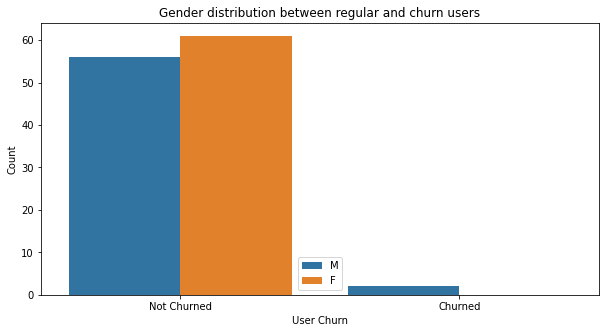

In [41]:
import seaborn as sns
#Plotting a bar plot to show gender distribution between regular and churn users
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Gender distribution between regular and churn users')
ax = sns.barplot(x = 'user_churn', y = 'count', data = churn_gender_df, hue = 'gender')

ax.set(xticklabels=['Not Churned', 'Churned'])

ax.set_ylabel('Count')
ax.set_xlabel('User Churn')
ax.legend()

%matplot plt

No handles with labels found to put in legend.


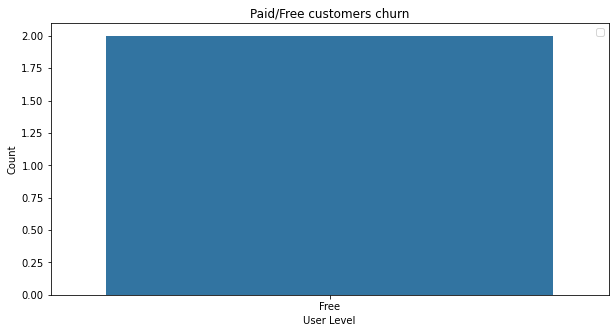

In [42]:
# Plotting a bar plot to show differense between Paid/Free customers churn
fig, ax = plt.subplots(figsize=(10, 5))

df_level_pd = df.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
plt.title('Paid/Free customers churn')
sns.barplot(data = df_level_pd, x = 'level', y = 'count', color = sns.color_palette()[0])

ax.set(xticklabels=['Free', 'Paid'])

ax.set_ylabel('Count')
ax.set_xlabel('User Level')
ax.legend()

No handles with labels found to put in legend.
UsageError: Line magic function `%matplot` not found.


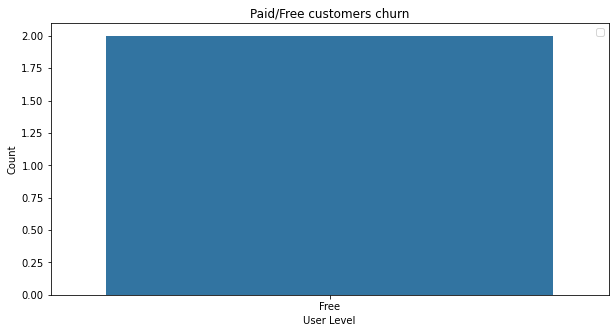

In [43]:
# Plotting a bar plot to show differense between Paid/Free customers churn
fig, ax = plt.subplots(figsize=(10, 5))

df_level_pd = df.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
plt.title('Paid/Free customers churn')
sns.barplot(data = df_level_pd, x = 'level', y = 'count', color = sns.color_palette()[0])

ax.set(xticklabels=['Free', 'Paid'])

ax.set_ylabel('Count')
ax.set_xlabel('User Level')
ax.legend()

%matplot plt

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.
UsageError: Line magic function `%matplot` not found.


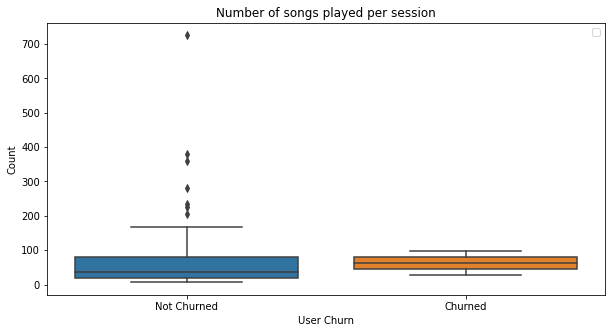

In [44]:
# Plotting Number of songs played per session

avg_songs_df = df.where(df.song.isNotNull()).groupby(['user_churn', 'userId', 'sessionId']).count()\
    .groupby(['user_churn', 'userId']).agg({'count': 'avg'}).toPandas()

fig, ax = plt.subplots(figsize=(10, 5))

plt.title('Number of songs played per session')
sns.boxplot('user_churn', y = 'avg(count)', data = avg_songs_df)

ax.set(xticklabels=['Not Churned', 'Churned'])

ax.set_ylabel('Count')
ax.set_xlabel('User Churn')
ax.legend()

%matplot plt

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.
UsageError: Line magic function `%matplot` not found.


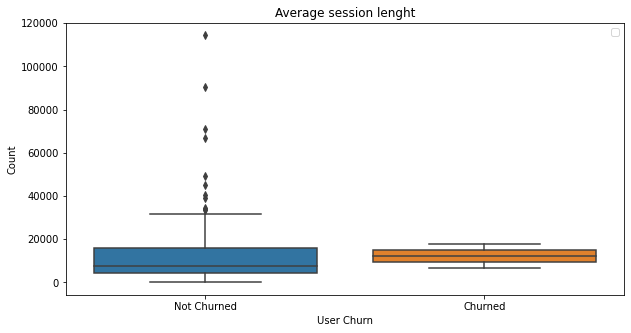

In [45]:
avg_session_df = df.groupby(['user_churn', 'userId', 'sessionId']) \
            .agg(((Fmax('ts') - Fmin('ts')) / 1000).alias('sessionlength')) \
            .groupby(['user_churn', 'userId']).agg({'sessionlength': 'avg'}).toPandas()

fig, ax = plt.subplots(figsize=(10, 5))

plt.title('Average session lenght')
sns.boxplot('user_churn', y = 'avg(sessionlength)', data = avg_session_df)

ax.set(xticklabels=['Not Churned', 'Churned'])

ax.set_ylabel('Count')
ax.set_xlabel('User Churn')
ax.legend()

%matplot plt

UsageError: Line magic function `%matplot` not found.


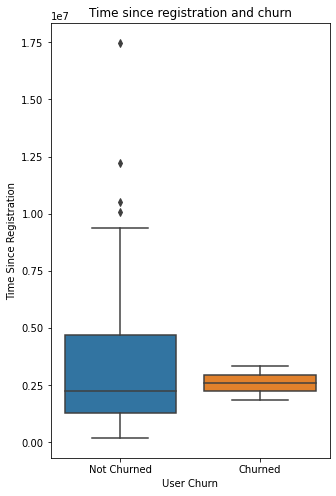

In [46]:
life_time_df = df.groupby(['user_churn', 'userId', 'ts', 'registration']).count() \
                    .withColumn('life_time', (df.ts - df.registration) / 1000) \
                    .groupBy('userId', 'user_churn').agg({'life_time' : 'max'}).toPandas()

# Plottint this dataframe
fig, ax = plt.subplots(figsize=(5, 8))

sns.boxplot(data=life_time_df, x='user_churn', y='max(life_time)')
plt.xlabel('User Churn')
plt.ylabel('Time Since Registration')
plt.title('Time since registration and churn')
ax.set(xticklabels=['Not Churned', 'Churned'])

%matplot plt

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
UsageError: Line magic function `%matplot` not found.


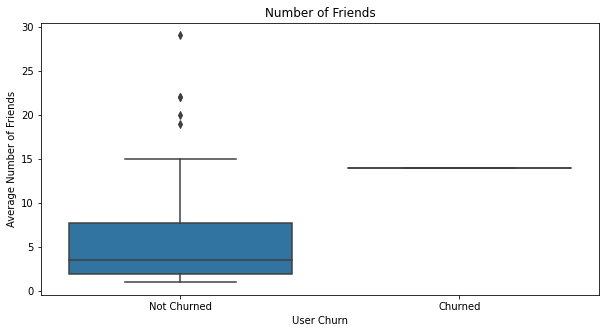

In [47]:
# dataframe whith friends
friends_df = df.where('page == "Add Friend"').groupby(['user_churn', 'userId']).count()\
                        .groupby(['user_churn', 'userId']).agg({'count': 'avg'}).toPandas()

# Plottint how Number of Friends correlations with Churn

fig, ax = plt.subplots(figsize=(10, 5))

plt.title('Number of Friends')
sns.boxplot('user_churn', y = 'avg(count)', data = friends_df)
plt.ylabel('Average Number of Friends')
plt.xlabel('User Churn')
ax.set(xticklabels=['Not Churned', 'Churned'])

%matplot plt

In [ ]:
features = []
songs_df = df.select('userID', 'page').where(df.page == 'NextSong').groupBy('userID').count() \
                    .withColumnRenamed('count', 'songs')

songs_df.show(5)

features.append(songs_df)

In [49]:
gender_df = df.groupby('userId').agg(first(when(col('gender') == "F", 1).otherwise(0)).alias('gender'))

gender_df.show(5)

features.append(gender_df)

+------+------+
|userId|gender|
+------+------+
|    51|     0|
|   124|     1|
|     7|     0|
|    54|     1|
|    15|     0|
+------+------+
only showing top 5 rows



In [50]:
thumbs_down_df = df.select('userId', 'page').where(df.page == 'Thumbs Down').groupBy('userId').count() \
                    .withColumnRenamed('count', 'thumbs_down')

thumbs_down_df.show(5)

features.append(thumbs_down_df)

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|    51|          9|
|   124|         10|
|     7|          1|
|    15|          7|
|    54|          5|
+------+-----------+
only showing top 5 rows



In [51]:
thumbs_up_df = df.select('userId', 'page').where(df.page == 'Thumbs Up').groupBy('userId').count() \
                    .withColumnRenamed('count', 'thumbs_up')
thumbs_up_df.show(5)

features.append(thumbs_up_df)

+------+---------+
|userId|thumbs_up|
+------+---------+
|    51|       74|
|   124|       44|
|    54|       30|
|    15|       27|
|   132|        1|
+------+---------+
only showing top 5 rows



In [52]:
time_since_registration_df = df.groupby(['userId', 'ts', 'registration']).count() \
                    .withColumn('life_time', (df.ts - df.registration) / 1000) \
                    .groupBy('userId').agg(Fmax('life_time')) \
                    .withColumnRenamed('max(life_time)', 'time_since_registration')

time_since_registration_df.show(5)

features.append(time_since_registration_df)

+------+-----------------------+
|userId|time_since_registration|
+------+-----------------------+
|    51|               917552.0|
|   124|              6818687.0|
|     7|              2063583.0|
|    54|              6564452.0|
|    15|              2137167.0|
+------+-----------------------+
only showing top 5 rows



In [53]:
avg_songs_p_session_df = df.where(df.song.isNotNull()).groupby(['userId', 'sessionId']).count()\
                            .groupby(['userId']).agg({'count': 'avg'}) \
                            .withColumnRenamed('avg(count)', 'avg_songs_p_session')

avg_songs_p_session_df.show(5)

features.append(avg_songs_p_session_df)

+------+-------------------+
|userId|avg_songs_p_session|
+------+-------------------+
|   124|              234.2|
|    51|              381.0|
|     7|                9.0|
|    15|              166.2|
|    54|  83.85714285714286|
+------+-------------------+
only showing top 5 rows



In [54]:
songs_in_playlist_df = df.select('userID', 'page') \
                            .where(df.page == 'Add to Playlist').groupBy('userID').count() \
                            .withColumnRenamed('count', 'songs_in_playlist')

songs_in_playlist_df.show(5)

features.append(songs_in_playlist_df)

+------+-----------------+
|userID|songs_in_playlist|
+------+-----------------+
|    51|               37|
|   124|               33|
|    15|               21|
|    54|               12|
|   101|               27|
+------+-----------------+
only showing top 5 rows



In [55]:
number_of_friends_df = df.where('page == "Add Friend"').groupby(['userId']).count()\
                        .groupby(['userId']).agg({'count': 'avg'}).withColumnRenamed('avg(count)', 'number_of_friends')
                                                                 
number_of_friends_df.show(5)

features.append(number_of_friends_df)

+------+-----------------+
|userId|number_of_friends|
+------+-----------------+
|    51|             29.0|
|   124|             22.0|
|     7|              1.0|
|    54|             11.0|
|    15|             13.0|
+------+-----------------+
only showing top 5 rows



In [56]:
help_df = df.groupby('userId').agg(Fsum(when(col('page') == 'Help', 1).otherwise(0)).alias('help_visits'))

help_df.show(5)

features.append(help_df)

+------+-----------+
|userId|help_visits|
+------+-----------+
|    51|          7|
|   124|          7|
|     7|          0|
|    54|          6|
|    15|          2|
+------+-----------+
only showing top 5 rows



In [57]:
settings_df = df.groupby('userId').agg(Fsum(when(col('page') == 'Settings', 1).otherwise(0)).alias('settings_visits'))

settings_df.show(5)

features.append(settings_df)

+------+---------------+
|userId|settings_visits|
+------+---------------+
|    51|              9|
|   124|             10|
|     7|              0|
|    54|              2|
|    15|             10|
+------+---------------+
only showing top 5 rows



In [58]:
errors_df = df.groupby('userId').agg(Fsum(when(col('page') == 'Error', 1).otherwise(0)).alias('errors'))

errors_df.show(5)

features.append(errors_df)

+------+------+
|userId|errors|
+------+------+
|    51|     1|
|   124|     4|
|     7|     0|
|    54|     2|
|    15|     2|
+------+------+
only showing top 5 rows



In [59]:
downgrade_df = df.select('userId', 'downgrade').dropDuplicates()

downgrade_df.show(5)

features.append(downgrade_df)

+------+---------+
|userId|downgrade|
+------+---------+
|    73|        0|
|    50|        0|
|    30|        0|
|     4|        0|
|    65|        0|
+------+---------+
only showing top 5 rows



In [60]:
level_df = df.groupby('userId').agg(last(when(col('level') == 'paid', 1).otherwise(0)).alias('level'))

level_df.show(5)

features.append(level_df)

+------+-----+
|userId|level|
+------+-----+
|    51|    1|
|   124|    1|
|     7|    0|
|    54|    1|
|    15|    0|
+------+-----+
only showing top 5 rows



In [ ]:
churn = df.select('userId', 'user_churn').dropDuplicates()

churn.show(5)

features.append(churn)

In [62]:
print(features)

[DataFrame[userID: string, songs: bigint], DataFrame[userId: string, gender: int], DataFrame[userId: string, thumbs_down: bigint], DataFrame[userId: string, thumbs_up: bigint], DataFrame[userId: string, time_since_registration: double], DataFrame[userId: string, avg_songs_p_session: double], DataFrame[userID: string, songs_in_playlist: bigint], DataFrame[userId: string, number_of_friends: double], DataFrame[userId: string, help_visits: bigint], DataFrame[userId: string, settings_visits: bigint], DataFrame[userId: string, errors: bigint], DataFrame[userId: string, downgrade: int], DataFrame[userId: string, level: int], DataFrame[userId: string, user_churn: int]]


In [63]:
final_df = songs_df

def merging_dataframes(a_df, b_df):
    '''  
    INPUT: 
    a_df, b_df - dataframes to be merged
    
    OUTPUT: 
    merged_df - merged dataframe
    
    Description: 
    Join dataframes
    '''
    
    merged_df = b_df.join(a_df, on=['userId'], how='left')
    
    return merged_df

for names in features[1:]:
    final_df = merging_dataframes(final_df, names)

# fill nans
final_df = final_df.na.fill(0)
final_df.show(5)

+------+----------+-----+---------+------+---------------+-----------+-----------------+-----------------+-------------------+-----------------------+---------+-----------+------+-----+
|userId|user_churn|level|downgrade|errors|settings_visits|help_visits|number_of_friends|songs_in_playlist|avg_songs_p_session|time_since_registration|thumbs_up|thumbs_down|gender|songs|
+------+----------+-----+---------+------+---------------+-----------+-----------------+-----------------+-------------------+-----------------------+---------+-----------+------+-----+
|    10|         0|    1|        0|     0|              1|          0|              3.0|                1|               57.0|               819877.0|        3|          0|     0|    0|
|   100|         0|    1|        0|     0|              1|          1|              6.0|                6|  84.66666666666667|               900862.0|       16|          4|     0|  254|
|   101|         0|    1|        0|     2|              2|          8|

In [64]:
final_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- user_churn: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- errors: long (nullable = true)
 |-- settings_visits: long (nullable = true)
 |-- help_visits: long (nullable = true)
 |-- number_of_friends: double (nullable = false)
 |-- songs_in_playlist: long (nullable = true)
 |-- avg_songs_p_session: double (nullable = false)
 |-- time_since_registration: double (nullable = false)
 |-- thumbs_up: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- songs: long (nullable = true)



**MODELING**

In [65]:
final_df.columns

['userId',
 'user_churn',
 'level',
 'downgrade',
 'errors',
 'settings_visits',
 'help_visits',
 'number_of_friends',
 'songs_in_playlist',
 'avg_songs_p_session',
 'time_since_registration',
 'thumbs_up',
 'thumbs_down',
 'gender',
 'songs']

In [66]:
# Create VectorAssembler and StandardScaler objects
# numeric features transform separately from binary
num_vector = VectorAssembler(inputCols=['downgrade', 'errors', 'settings_visits', 
                                        'help_visits', 'number_of_friends', 'songs_in_playlist', 
                                        'avg_songs_p_session', 'time_since_registration', 'thumbs_up', 
                                        'thumbs_down', 'songs','level', 'gender'], 
                             outputCol='num_vector_assem')

num_scaler = StandardScaler(inputCol='num_vector_assem', outputCol ='num_vector_sc', withStd=True, withMean=True)

final_vector = VectorAssembler(inputCols=['level', 'gender']+['num_vector_sc'], 
                               outputCol='features_vector')

In [67]:
# Transform data
data = num_vector.transform(final_df)

feature_standardize = num_scaler.fit(data)
data = feature_standardize.transform(data)

data = final_vector.transform(data)

In [68]:
#final data
data = data.select(data.user_churn, data.features_vector)
data.show(5)

+----------+--------------------+
|user_churn|     features_vector|
+----------+--------------------+
|         0|[1.0,0.0,-0.20587...|
|         0|[1.0,0.0,-0.20587...|
|         0|[1.0,0.0,-0.20587...|
|         0|[0.0,0.0,-0.20587...|
|         0|[0.0,0.0,-0.20587...|
+----------+--------------------+
only showing top 5 rows



In [69]:
# Split Test and Train set
train, test = data.randomSplit([0.6, 0.4], seed=42)

In [70]:
# function for printing results
def evaluate_print(model_result, model_name, start, end):
    ''' 
    INPUT:
    model_result : result
    model_name : string
    start, end : training time start and end
    
    OUTPUT: list
    
    Description:
    The function return list of results and prints results and total time of the training
    
    '''
    
    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
    evaluator.setLabelCol('user_churn')
    accuracy = evaluator.evaluate(model_result, {evaluator.metricName : 'accuracy'})
    f1 = evaluator.evaluate(model_result, {evaluator.metricName : 'f1'})
    time = (end - start)/60
    
    result = [model_name, round(accuracy,3), round(f1,3), round(time,1)]
    
    print('{} performance metrics:'.format(model_name))
    print('Accuracy: {}'.format(accuracy))
    print('F-1 Score: {}'.format(f1))
    print('Total training time: {} minutes'.format(time))
    

In [71]:
def reports(model_result):
    '''
    INPUT:
    model_result : list
    
    OUTPUT: None
    
    Description:
    The function aggregate and prints results of models
    
    '''
    print(model_result[0])
    print('Accuracy: {}'.format(model_result[1]))
    print('F-1 Score: {}'.format(model_result[2]))
    print('Total training time: {} minutes'.format(model_result[3]))
    
    print()

**BASELINE MODEL**

In [72]:
#baseline model
baseline = test.withColumn('prediction', lit(0.0))
baseline.show(5)

+----------+--------------------+----------+
|user_churn|     features_vector|prediction|
+----------+--------------------+----------+
|         0|[0.0,0.0,-0.20587...|       0.0|
|         0|[0.0,0.0,-0.20587...|       0.0|
|         0|[0.0,0.0,-0.20587...|       0.0|
|         0|[0.0,0.0,-0.20587...|       0.0|
|         0|[0.0,0.0,-0.20587...|       0.0|
+----------+--------------------+----------+
only showing top 5 rows



In [73]:
#print baseline model
baseline_result = evaluate_print(baseline, 'Baseline', 0, 0)

Baseline performance metrics:
Accuracy: 1.0
F-1 Score: 1.0
Total training time: 0.0 minutes


In [74]:
# start training
START = time.time()

In [76]:
###LOGISTIC REGRESSION

In [75]:
numFolds = 3
lr = LogisticRegression(maxIter=10, labelCol='user_churn', featuresCol='features_vector')
evaluator = MulticlassClassificationEvaluator(labelCol='user_churn')

pipeline = Pipeline(stages=[lr])
lr_paramGrid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.1, 0.01, 0.001])
                .build())


crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=lr_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

lr_start = time.time()
lr_model = crossval.fit(train)
lr_end = time.time()

In [78]:
lr_results = lr_model.transform(test)

lr_safe = evaluate_print(lr_results, 'Logistic Regression', lr_start, lr_end)

best_param = list(lr_model.getEstimatorParamMaps()[np.argmax(lr_model.avgMetrics)].values())
print('Best regression parameter is {}'.format(best_param[0]))

Logistic Regression performance metrics:
Accuracy: 1.0
F-1 Score: 1.0
Total training time: 7.171402581532797 minutes
Best regression parameter is 0.1


In [80]:
###RANDOM FOREST CLASSIFIER

In [79]:
numFolds = 3
rf = RandomForestClassifier(labelCol='user_churn', featuresCol='features_vector', seed = 42)
evaluator = MulticlassClassificationEvaluator(labelCol='user_churn')

pipeline = Pipeline(stages=[rf])
rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10,20])
             .addGrid(rf.maxDepth, [10,20])
             .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=rf_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

rf_start = time.time()
rf_model = crossval.fit(train)
rf_end = time.time()

In [83]:
rf_results = rf_model.transform(test)

rf_safe = evaluate_print(rf_results, 'Random Forest', rf_start, rf_end)

best_param = list(rf_model.getEstimatorParamMaps()[np.argmax(rf_model.avgMetrics)].values())
print('Best number of trees {}, best depth {}'.format(best_param[0], best_param[1]))

Random Forest performance metrics:
Accuracy: 1.0
F-1 Score: 1.0
Total training time: 7.705735313892364 minutes
Best number of trees 10, best depth 10


In [94]:
### GRADIENT BOOSTED TREES

In [85]:
numFolds = 3
gbt = GBTClassifier(labelCol='user_churn', featuresCol='features_vector', seed = 42)
evaluator = MulticlassClassificationEvaluator(labelCol='user_churn')

pipeline = Pipeline(stages=[gbt])
gbt_paramGrid = (ParamGridBuilder()
                 .addGrid(gbt.maxIter, [10,20])
                 .addGrid(gbt.maxDepth, [10,20])
                 .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=gbt_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

gbt_start = time.time()
gbt_model = crossval.fit(train)
gbt_end = time.time()

In [86]:
gbt_results = gbt_model.transform(test)

gbt_safe = evaluate_print(gbt_results, 'Gradient Boosted Trees', gbt_start, gbt_end)

best_param = list(gbt_model.getEstimatorParamMaps()[np.argmax(rf_model.avgMetrics)].values())
print('Best number of iterations {}, best depth {}'.format(best_param[0], best_param[1]))

Gradient Boosted Trees performance metrics:
Accuracy: 0.9615384615384616
F-1 Score: 0.9803921568627451
Total training time: 33.289291846752164 minutes
Best number of iterations 10, best depth 10


In [92]:
END = time.time()